In [ ]:
import tensorflow as tf, numpy as np, random
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class Graph(object):

    __slots__ = ['adj_list', 'embeddings', 'embedding_file']

    max_vertices = 1000

    def __new__(cls, edges=None, **kwargs):
        obj = object.__new__(cls)
        adj_list = dict()
        is_embedding_avail = False
        if edges is None:
            if kwargs.get('load_from', None) is not None:
                graph_file = kwargs['load_from']
                is_embedding_avail = True
                adj_list = np.load(graph_file, allow_pickle=True).item()
            else:
                size = random.randint(0, cls.max_vertices)
                for i in range(size):
                    num_adjs = random.randint(0, 6)
                    adj_nodes = []
                    for j in range(num_adjs):
                        adj_nodes.append(random.randint(0, size - 1))
                    adj_list[i] = set(adj_nodes)
                    if i in adj_list[i]:
                        adj_list[i].remove(i)
                graph_file = kwargs.get('save_to', "/content/drive/My Drive/linkpred/graphs/rand_0.npy")
                np.save(graph_file, adj_list)
        else:
            for edge in edges:
                if edge[0] not in adj_list:
                    adj_list[edge[0]] = set()
                if edge[1] not in adj_list:
                    adj_list[edge[1]] = set()
                adj_list[edge[0]].add(edge[1])
            graph_file = kwargs.get('save_to', "/content/drive/My Drive/linkpred/graphs/fixed_0.npy")
            np.save(graph_file, adj_list)
        
        obj.adj_list = adj_list
        obj.embeddings = dict()
        obj.embedding_file = graph_file[0:-4] + "_embedding.npy"
        if is_embedding_avail:
            obj.load_embeddings()
        else:
            obj.init_embeddings(kwargs.get('embedding_size', 10))
            obj.save_embeddings()
        return obj

    def init_embeddings(self, d):
        for i in self.adj_list:
            self.embeddings[i] = tf.Variable(initial_value=tf.random.normal((d,)), dtype=tf.float32)
            for adj in self.adj_list[i]:
                self.embeddings[adj] = tf.Variable(initial_value=tf.random.normal((d,)), dtype=tf.float32)
    
    def add_edge(self, source, dest, **kwargs):
        if source in self.adj_list and dest in self.adj_list:
            self.adj_list[source].add(dest)
            self.update_embeddings(source, steps=20, save_freq=5, **kwargs)
            self.update_embeddings(dest, steps=20, save_freq=5, **kwargs)
    
    def remove_edge(self, source, dest, **kwargs):
        if source in self.adj_list and dest in self.adj_list:
            self.adj_list[source].remove(dest)
            self.update_embeddings(source, steps=10, save_freq=2, **kwargs)
            self.update_embeddings(dest, steps=10, save_freq=2, **kwargs)
    
    def depth_first_search(self, source, sim, max_depth=float('inf'), rand_others=1, edge_weight_func=tf.math.exp):
        visited = set()
        sim_pairs = 0
        from collections import deque as Stack
        s = Stack()
        s.append((source, 0))
        while s:
            node, curr_depth = s.pop()
            if node not in visited and curr_depth < max_depth:
                visited.add(node)
                for next_node in self.adj_list[node]:
                    sim_pairs += sim(self, source, next_node, edge_weight_func(tf.constant(-curr_depth, dtype=tf.float32)))
                    s.append((next_node, curr_depth + 1))
        while rand_others > 0:
            other = random.randint(0, len(self.adj_list) - 1)
            if other not in self.adj_list[source] and other != source:
                sim_pairs += 1/sim(self, source, other, 1.)
                rand_others -= 1
        return sim_pairs
    
    def save_embeddings(self):
        np.save(self.embedding_file, self.embeddings, allow_pickle=True)

    def load_embeddings(self):
        self.embeddings = np.load(self.embedding_file, allow_pickle=True).item()
    
    def fit_embeddings(self, steps=2, save_freq=1, **kwargs):
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.RMSprop(kwargs.get('learning_rate', 0.001)))
        for step in range(steps):
            vars = [self.embeddings[i] for i in self.adj_list if self.adj_list[i]]
            with tf.GradientTape(persistent=True) as tape:
                total_loss = 0
                tape.watch(vars)
                for i in self.adj_list:
                    total_loss += self.depth_first_search(i, kwargs['dissimilarity_measure'], kwargs.get('max_depth', 2), kwargs.get('rand_others', 1))
            grads = tape.gradient(total_loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if (step + 1) % save_freq == 0:
                self.save_embeddings()
            print("Step %s complete with a loss of %s"%((step + 1), total_loss))
    
    def update_embeddings(self, source, steps=2, save_freq=1, **kwargs):
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.RMSprop(kwargs.get('learning_rate', 0.001)))
        for step in range(steps):
            vars = [self.embeddings[i] for i in self.adj_list if self.adj_list[i]]
            with tf.GradientTape(persistent=True) as tape:
                total_loss = 0
                tape.watch(vars)
                total_loss += self.depth_first_search(source, kwargs['dissimilarity_measure'], kwargs.get('max_depth', 2), kwargs.get('rand_others', 1))
            grads = tape.gradient(total_loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if (step + 1) % save_freq == 0:
                self.save_embeddings()
            print("Step %s complete with a loss of %s"%((step + 1), total_loss))
    
    def uv_dist(self, u, v):
        from collections import deque as Queue
        visited = set()
        q = Queue()
        q.append((u, 0))
        while q:
            node, curr_dist = q.popleft()
            if node == v:
                return curr_dist
            if node not in visited:
                visited.add(node)
                for next_node in self.adj_list[node]:
                    q.append((next_node, curr_dist + 1))
        return float('inf')

graph = Graph(load_from="/content/drive/My Drive/linkpred/graphs/rand_5.npy")
graph.adj_list

{0: {148},
 1: {92, 324, 550, 573},
 2: {39, 79, 94, 271},
 3: {4, 132, 582},
 4: {7, 12, 40, 101, 618},
 5: {37, 503, 624},
 6: {250, 310, 509},
 7: {305, 439},
 8: {86, 125, 137, 162, 272, 640},
 9: {112, 327, 407, 557},
 10: {66, 126, 191, 225, 324},
 11: {207, 382, 456},
 12: {177, 212, 285, 322},
 13: {16, 308, 318, 325, 601, 630},
 14: {243, 340, 464, 506, 609, 677},
 15: {121, 140, 248, 417},
 16: {532},
 17: {252, 449, 484, 488, 673},
 18: {359, 512},
 19: {72, 105, 462},
 20: {1, 464, 644},
 21: {114, 199, 403, 448},
 22: {34, 444},
 23: {289, 315, 515, 609, 613},
 24: set(),
 25: {519, 603, 612, 667},
 26: set(),
 27: {192, 470, 587, 652, 662},
 28: {260, 309, 496},
 29: {130},
 30: {225, 278},
 31: {20, 207, 234, 427, 557},
 32: {12, 241, 577},
 33: {206, 247, 554, 625, 655},
 34: {33, 651},
 35: {9, 658},
 36: {273, 309, 463, 546},
 37: set(),
 38: {23, 107, 357, 515},
 39: {532, 590},
 40: {99, 193, 282, 403},
 41: {129, 180, 186, 479, 496, 603},
 42: {137, 347},
 43: {7, 

In [ ]:
def l2norm(g, u, v, w):
    h, t = g.embeddings[u], g.embeddings[v]
    return tf.reduce_sum(tf.math.squared_difference(h, t))*w

def l1norm(g, u, v, w):
    h, t = g.embeddings[u], g.embeddings[v]
    return tf.reduce_sum(tf.math.subtract(h, t))*w

def vec_cosine(g, i, j):
    u, v = g.embeddings[i], g.embeddings[j]
    dot = tf.reduce_sum(u*v)
    mod_u = tf.math.sqrt(tf.reduce_sum(tf.math.square(u)))
    mod_v = tf.math.sqrt(tf.reduce_sum(tf.math.square(v)))
    return dot/(mod_u*mod_v)

def square_diff(g, i, j):
    u, v = g.embeddings[i], g.embeddings[j]
    return tf.math.sqrt(tf.reduce_sum(tf.math.squared_difference(u, v)))

In [ ]:
graph.fit_embeddings(dissimilarity_measure=l2norm, steps=100, learning_rate=0.001, save_freq=5, max_depth=2, rand_others=0)

Step 1 complete with a loss of tf.Tensor(867444.8, shape=(), dtype=float32)
Step 2 complete with a loss of tf.Tensor(867024.4, shape=(), dtype=float32)
Step 3 complete with a loss of tf.Tensor(866720.3, shape=(), dtype=float32)
Step 4 complete with a loss of tf.Tensor(866465.9, shape=(), dtype=float32)
Step 5 complete with a loss of tf.Tensor(866239.8, shape=(), dtype=float32)
Step 6 complete with a loss of tf.Tensor(866031.75, shape=(), dtype=float32)
Step 7 complete with a loss of tf.Tensor(865838.94, shape=(), dtype=float32)
Step 8 complete with a loss of tf.Tensor(865655.3, shape=(), dtype=float32)
Step 9 complete with a loss of tf.Tensor(865479.56, shape=(), dtype=float32)
Step 10 complete with a loss of tf.Tensor(865310.8, shape=(), dtype=float32)
Step 11 complete with a loss of tf.Tensor(865146.5, shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [ ]:
graph.embedding_file = "/content/drive/My Drive/linkpred/graphs/rand_7_embedding.npy"
pairs = [(0, 5), (1, 4), (2, 9), (3, 5), (3, 12), (6, 15), (7, 18), (8, 2), (8, 18), (9, 16), (11, 6), (12, 11), (14, 20), (16, 11), (19, 9), (19, 12), (20, 12), (20, 14)]
max_adds = len(pairs)
for k in range(max_adds):
    graph.remove_edge(pairs[k][0], pairs[k][1], dissimilarity_measure=l2norm, learning_rate=0.01, max_depth=2, rand_others=3)
np.save("/content/drive/My Drive/linkpred/graphs/rand_7.npy", graph.adj_list)

Step 1 complete with a loss of tf.Tensor(119.23016, shape=(), dtype=float32)
Step 2 complete with a loss of tf.Tensor(110.669426, shape=(), dtype=float32)
Step 3 complete with a loss of tf.Tensor(104.839836, shape=(), dtype=float32)
Step 4 complete with a loss of tf.Tensor(100.28233, shape=(), dtype=float32)
Step 5 complete with a loss of tf.Tensor(96.2846, shape=(), dtype=float32)
Step 6 complete with a loss of tf.Tensor(92.68216, shape=(), dtype=float32)
Step 7 complete with a loss of tf.Tensor(89.48365, shape=(), dtype=float32)
Step 8 complete with a loss of tf.Tensor(86.83286, shape=(), dtype=float32)
Step 9 complete with a loss of tf.Tensor(84.06832, shape=(), dtype=float32)
Step 10 complete with a loss of tf.Tensor(81.51851, shape=(), dtype=float32)
Step 1 complete with a loss of tf.Tensor(14.826947, shape=(), dtype=float32)
Step 2 complete with a loss of tf.Tensor(12.07638, shape=(), dtype=float32)
Step 3 complete with a loss of tf.Tensor(12.076948, shape=(), dtype=float32)
Step

ValueError: ignored

In [ ]:
graph.embeddings

{0: <tf.Variable 'Variable:0' shape=(100,) dtype=float32, numpy=
 array([ 0.02168293, -0.14363995,  0.17937118,  0.11330377, -0.01934597,
         0.09562253,  0.29269353,  0.03820068,  0.02014016, -0.14946519,
         0.05045295,  0.40154865, -0.00919253, -0.04711047, -0.01794619,
         0.07707609, -0.06640527, -0.14165257, -0.11071814, -0.00499452,
         0.08772951,  0.18450367,  0.02163534,  0.14993903, -0.08644152,
         0.02669626,  0.05286725,  0.1335257 ,  0.08672091, -0.17068581,
        -0.1856621 ,  0.16239199, -0.13875012, -0.15567814,  0.22041371,
        -0.16226245, -0.04572229,  0.14067708,  0.11430629, -0.2603048 ,
        -0.2726086 ,  0.04025995,  0.20493864, -0.11288813, -0.06351186,
        -0.2673261 ,  0.21367943,  0.02757077,  0.11103905, -0.2764971 ,
         0.21429703, -0.14977963, -0.05585113,  0.00232014,  0.10705838,
         0.14525901,  0.38740268,  0.1813118 , -0.14736514, -0.12238657,
        -0.12675875, -0.10236188,  0.01531697,  0.06699765,

In [ ]:
def scatter_plot(dist_func):
    true_links = []
    true_links_nodes = []
    false_links = []
    false_links_nodes = []
    for i in graph.adj_list:
        for j in range(len(graph.adj_list)):
            if j in graph.adj_list[i]:
                true_links.append(dist_func(graph, i, j).numpy())
                true_links_nodes.append((i, j))
            elif j != i:
                false_links.append(dist_func(graph, i, j).numpy())
                false_links_nodes.append((i, j))
    plt.scatter([i for i in range(len(true_links))], true_links, color='red')
    plt.scatter([i for i in range(len(false_links))], false_links, color='blue')
    plt.show()
    return true_links, false_links, true_links_nodes, false_links_nodes

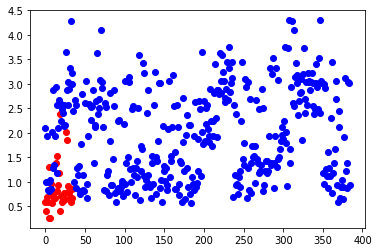

In [ ]:
true_links, false_links, true_pairs, false_pairs = scatter_plot(square_diff)

0 0.08333333333333333
1 0.08333333333333333
2 0.08333333333333333
3 0.08333333333333333
4 0.08333333333333333
5 0.08333333333333333
6 0.08333333333333333
7 0.08333333333333333
8 0.08333333333333333
9 0.08333333333333333
10 0.08333333333333333
11 0.08333333333333333
12 0.08333333333333333
13 0.08333333333333333
14 0.08333333333333333
15 0.08333333333333333
16 0.08333333333333333
17 0.08333333333333333
18 0.08333333333333333
19 0.08333333333333333
20 0.08333333333333333
21 0.08333333333333333
22 0.08333333333333333
23 0.08333333333333333
24 0.08333333333333333
25 0.08333333333333333
26 0.08333333333333333
27 0.08333333333333333
28 0.08333333333333333
29 0.08333333333333333
30 0.08333333333333333
31 0.08333333333333333
32 0.08333333333333333
33 0.08333333333333333
34 0.08333333333333333
35 0.08333333333333333
36 0.08333333333333333
37 0.08333333333333333
38 0.08333333333333333
39 0.08333333333333333
40 0.08333333333333333
41 0.08333333333333333
42 0.08333333333333333
43 0.0833333333333333

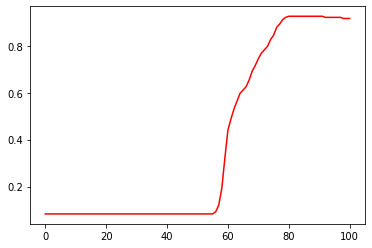

In [ ]:
def threshold(delta):
    is_link = tf.reduce_sum(tf.cast(tf.math.greater(tf.math.sigmoid(1/tf.convert_to_tensor(true_links)), tf.constant(delta)), dtype=tf.int64)).numpy()
    tp = is_link
    is_link = tf.reduce_sum(tf.cast(tf.math.less(tf.math.sigmoid(1/tf.convert_to_tensor(false_links)), tf.constant(delta)), dtype=tf.int64)).numpy()
    tn = is_link
    score = tn + tp
    n = len(graph.adj_list)
    return score/(n*n - n)

scores = []
for delta in range(0, 101):
    score = threshold(delta/100.)
    scores.append(score)
    print(delta, score)
    delta += 1
plt.plot([i for i in range(len(scores))], scores, color='red')
plt.show()